In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

## Learning a simple function

Let's try to learn a Gaussian

In [10]:
pi = torch.tensor(np.pi)

def Gauss(x):
    if type(x) == np.ndarray:
        x = torch.tensor(x)
        
    return 1 / (2*pi) * torch.exp( - x**2 / 2 )

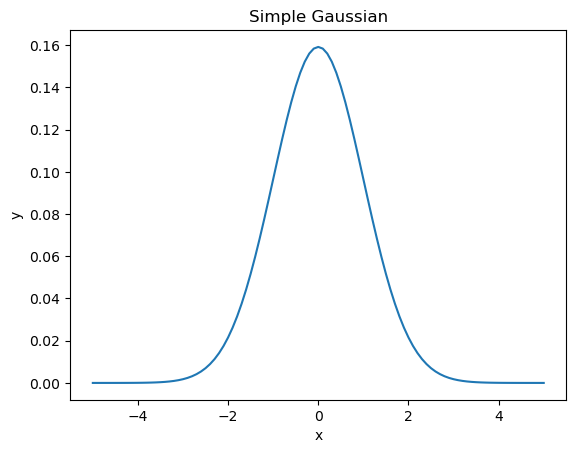

In [14]:
# PLOT

x = np.linspace(-5,5,101)
y = Gauss(x)

plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simple Gaussian');

In [84]:
# SIMPLE LINEAR MODEL

class LinModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.linear_ReLu_stack = nn.Sequential(
            nn.Linear(in_features=1,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=1),
            nn.ReLU(),
        )

    def forward(self,x):
        return self.linear_ReLu_stack(x)
    
# DEFINING MODEL

lin_model = LinModel()
print(lin_model)


LinModel(
  (linear_ReLu_stack): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): ReLU()
  )
)


In [85]:
# DATA
X = torch.linspace(-7,7,1001).view(-1,1)
y = Gauss(X)


In [88]:
# TRAINING

# TRAIN TEST SPLIT
train_size = int(0.8 * len(X))  
val_size = len(X) - train_size  
train_idx, val_idx = torch.utils.data.random_split(X, [train_size, val_size])
train_idx = train_idx.indices
val_idx = val_idx.indices
X_train = X[train_idx]
X_val = X[val_idx]
y_train = y[train_idx]
y_val = y[val_idx]

# OPTIMIZER
optimizer = optim.Adam(lin_model.parameters(),lr=1e-4)

# EXTERNAL PARAMETERS
n_epochs = 500
loss_fct = nn.MSELoss()
train_losses = []
val_losses = []
val_acc = []


# TRAINING + VALIDATION
for epochs in range(n_epochs):
    optimizer.zero_grad()

    # TRAINING
    pred_train = lin_model(X_train) 
    loss_train = loss_fct(pred_train,y_train)
    loss_train.backward()
    optimizer.step()

    train_losses.append(loss_train.item())

    # VALIDATION
    with torch.no_grad():
        pred_val = lin_model(X_val)
        loss_val = loss_fct(pred_val,y_val)
        val_losses.append(loss_val)

# INFERENCE
with torch.no_grad():
    predictions = lin_model(X)



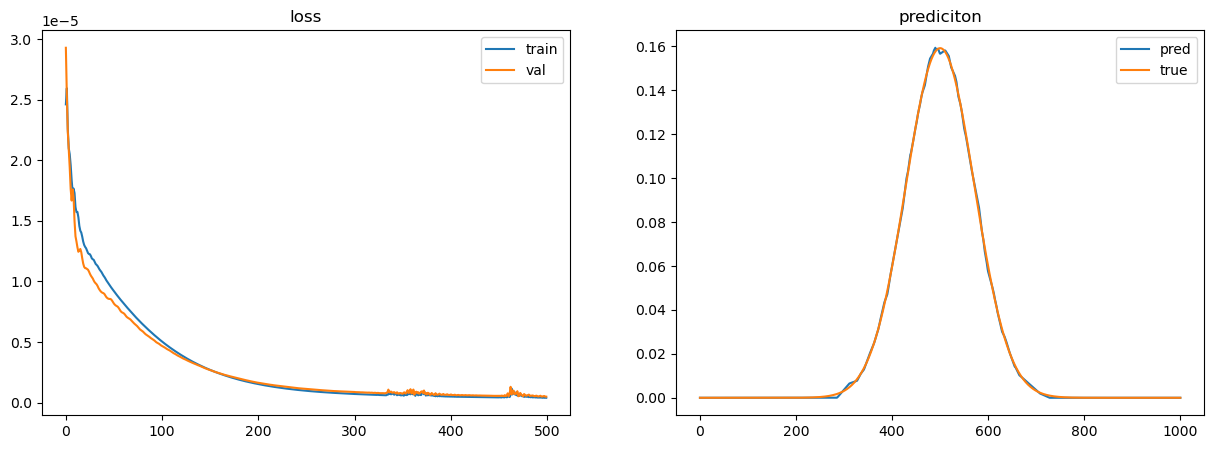

In [89]:

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15,5))

ax[0].plot(train_losses,label='train')
ax[0].plot(val_losses,label='val')
ax[0].legend()
ax[0].set_title('loss');

ax[1].plot(predictions,label='pred')
ax[1].plot(y,label='true')
ax[1].legend()
ax[1].set_title('prediciton');


## Learning XOR


XOR: $[0,1]^2 \to [0,1]$ not-linear saperable!

XOR(0,0) = XOR(1,1) = 0
XOR(1,0) = XOR(0,1) = 1

In [230]:
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]],dtype=torch.float32) # possible input states
y = torch.tensor([0,1,1,0],dtype=torch.float32) # possible output states 

print(f'{X.shape = }')
print(f'{y.shape = }')
print('\n')
print(f'{X.dtype = }')
print(f'{y.dtype = }')

X.shape = torch.Size([4, 2])
y.shape = torch.Size([4])


X.dtype = torch.float32
y.dtype = torch.float32


In [10]:
# XOR MODEL
class XORModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.xor_stack = nn.Sequential(
            nn.Linear(in_features=2,out_features=16),
            nn.Tanh(),
            nn.Linear(in_features=16,out_features=1),
            nn.Tanh(),
        )

    def forward(self,x):
        return self.xor_stack(x)

xor_model = XORModel()
print(xor_model)

XORModel(
  (xor_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=1, bias=True)
    (3): Tanh()
  )
)


100%|██████████| 10000/10000 [00:01<00:00, 6877.58it/s]


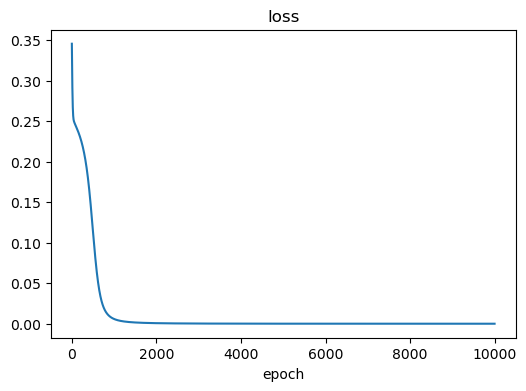

In [11]:
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]],dtype=torch.float32) # possible input states
y = torch.tensor([[0],[1],[1],[0]],dtype=torch.float32) # possible output states 

xor_model = XORModel()

optimizer = optim.Adam(xor_model.parameters())

loss_fct = nn.MSELoss()
losses = []

n_epochs = 10_000

for epoch in tqdm.tqdm(range(n_epochs)):
    optimizer.zero_grad()

    pred = xor_model(X) # forward pass
    loss = loss_fct(pred,y)
    loss.backward() # back propagation
    optimizer.step() # update params

    losses.append(loss.item())


fig = plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title('loss')
plt.xlabel('epoch');


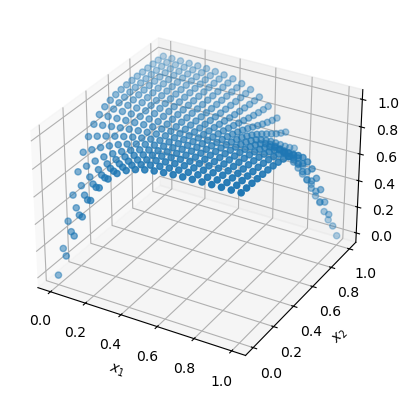

In [12]:
# DICISION BOUNDARY
x1 = torch.linspace(0,1,21)
x2 = torch.linspace(0,1,21)

xx,yy = torch.meshgrid(x1,x2,indexing='ij')
pts = torch.stack([xx.ravel(),yy.ravel()],dim=1)

z = xor_model(pts).detach().view(len(x1),len(x2)) # detach 


# PLOT DICISION BOUNDARY
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xx,yy,z,marker='o')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$');
